In [ ]:
import ants
import numpy as np

In [ ]:
fname1 = ants.get_ants_data('r16')
fname2 = ants.get_ants_data('r64')
print(fname1)
print(fname2)

In [ ]:
img1 = ants.image_read(fname1)
img2 = ants.image_read(fname2)
print(img1)

In [ ]:
arr_4d = np.random.randn(70,70,70,10).astype('float32')
img_fmri = ants.from_numpy(arr_4d, has_components=True)
print(img_fmri)

# todo : tester aussi from_nibabel/ to_nibabel (-> .nii.gz)
#        nifti_to_ants

In [ ]:
img = ants.image_read(ants.get_ants_data('r16'))
img = ants.resample_image(img, (64,64), 1, 0)
mask = ants.get_mask(img)
img_seg = ants.atropos(a=img, 
                       m='[0.2,1x1]', 
                       c='[2,0]', 
                       i='kmeans[3]', 
                       x=mask)
print(img_seg.keys())
ants.plot(img_seg['segmentation'])

In [ ]:
mg = ants.image_read( ants.get_ants_data('r16') ,2)
mask = ants.get_mask( img ).threshold_image( 1, 2 )
segs=ants.atropos( a = img, 
                   m = '[0.2,1x1]', 
                   c = '[2,0]',  
                   i = 'kmeans[3]', 
                   x = mask )
thickimg = ants.kelly_kapowski(s=segs['segmentation'], 
                               g=segs['probabilityimages'][1],
                               w=segs['probabilityimages'][2], 
                               its=45, 
                               r=0.5, 
                               m=1)
print(thickimg)
img.plot(overlay=thickimg, overlay_cmap='jet')

# Transform manually template 

In [ ]:
import nrrd
import nibabel as nib
import numpy as np
import os
from pathlib import Path

template_file = '/Users/mahdi/stage-2022-mahdi/src/allen_template_25.nii.gz'
template_ras_file = "/Users/mahdi/stage-2022-mahdi/src/allen_template_25_manualRAS.nii.gz"

resolution = 25
res_avgt_mm = 70 / 1e3
avgt_offset = np.array([-5.675, -8.79448, -8.450335, 0])

# Load and manually transform the template
vol = nib.load(template_file).get_fdata()

vol_ras = np.moveaxis(vol, (0,1,2), (1,2,0))
vol_ras = np.flip(vol_ras, axis=2)
vol_ras = np.flip(vol_ras, axis=1)

affine = np.eye(4) * res_avgt_mm

img_ras = nib.Nifti1Image(vol_ras, affine)
nib.save(img_ras, template_ras_file)

# load reference
avgt = nib.load('/Users/mahdi/stage-2022-mahdi/src/AVGT.nii.gz')
ref_vol = avgt.get_fdata()

# load moving
allen = nib.load('/Users/mahdi/stage-2022-mahdi/src/allen_template_25_manualRAS.nii.gz')
allen_vol = allen.get_fdata()


allen_vol = allen_vol.astype(float)
ref_vol = ref_vol.astype(float)

fixed = ants.from_numpy( ref_vol ).resample_image((164, 212, 158),1,0)
moving = ants.from_numpy( allen_vol ).resample_image((164, 212, 158),1,0)

fixed.plot_ortho()
moving.plot_ortho()
mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='SyN' )

warped_moving = ants.apply_transforms(fixed=fixed, moving=moving, 
                                          transformlist=mytx['fwdtransforms'])
fixed.plot_ortho_double(warped_moving)
affine_offset = affine.copy()
affine_offset[:,3] + avgt_offset

warped_vol = warped_moving.numpy()
# Saving the volume (nifti)
img = nib.Nifti1Image(warped_vol, affine_offset)
nib.save(img, '/Users/mahdi/stage-2022-mahdi/src/template_reg.nii.gz')

In [ ]:
warped_moving.shape

### essais nii nibabel ants

In [ ]:
# todo : tester aussi from_nibabel/ to_nibabel (-> .nii.gz)
#        nifti_to_ants

import ants
import nrrd
import numpy as np

array, metadata = nrrd.read('/Users/mahdi/stage-2022-mahdi/src/average_template_25.nrrd')

img = ants.from_numpy(array) # convertir en float

orientation = ants.get_orientation(img)

print(orientation)

In [ ]:
import ants
import numpy as np
import matplotlib.pyplot as plt

img = ants.image_read(ants.get_ants_data('r16'))
mask = ants.get_mask(img, cleanup=15, low_thresh=55)
ants.plot(mask)
nimg = img * mask
ants.plot(nimg,black_bg=False)


In [ ]:
import numpy as np
import nibabel as nib


ants.ANTsImage.pixeltype = np.int32
img = nib.load('/Users/mahdi/stage-2022-mahdi/src/288169135_projection_density_50.nii.gz')

vol = img.get_fdata().astype(np.float32)

img = ants.from_numpy( vol ).resample_image((164, 212, 158),1,0)

img.plot_ortho()

for z in range(158):
    for y in range(212):
        for x in range(164):
            if vol[x, y, z] < 1e-01:
                vol[x, y, z] = 0.0

img = ants.from_numpy( vol )

img.plot_ortho()

 # Removing background 
    # mask = ants.get_mask(warped_moving)
    # warped_moving = warped_moving * mask



#####BINARIZED FORMULA######    S
    #warped_moving = warped_moving > 1e-01

In [ ]:
import cv2

tmp = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2GRAY)
_,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
b, g, r = cv2.split(img.numpy())
rgba = [b,g,r, alpha]
dst = cv2.merge(rgba,4)


In [ ]:
from PIL import Image
import numpy as np

image = Image.open('../images/288169135_proj_density_/288169266.jpg')

vol = np.asarray(image)

img = nib.Nifti1Image(vol, np.eye(4))

nib.save(img, '../../niftis/test.nii')

# test fusions 2 niftis

In [1]:
import ants
import numpy as np
import nibabel as nib
import PIL

In [17]:
vol = nib.load('/Users/mahdi/stage-2022-mahdi/niftis/485847695_AIp_R_proj_density_100.nii.gz').get_fdata()
voll = nib.load('/Users/mahdi/stage-2022-mahdi/niftis/180403712_ECT_R_proj_density_100.nii.gz').get_fdata()

In [11]:
print(vol[109,97,117],
      voll[109,97,117])   

0.0 0.0004686765605583787


In [19]:
print(vol[117,69,76],
      voll[117,69,76])

0.00012096612044842914 0.0014684608904644847


In [18]:
rgb = np.zeros((164,212,158,1,1), [('R', 'u1'), ('G','u1'), ('B', 'u1'), ('A', 'u1')])

for i in range(164):
    for j in range(212):
        for k in range(158):
            if vol[i,j,k] == 0.0 and voll[i,j,k] == 0.0:
                rgb[i,j,k] = (0, 0, 0, 0)
            else:
                rgb[i,j,k] = (vol[i,j,k] * 255, voll[i,j,k] * 255, 0, 255)

img_ = nib.Nifti1Image(rgb, affine)
nib.save(img_, '/Users/mahdi/stage-2022-mahdi/niftis/rbg_180601025_183171679.nii.gz')

In [21]:
print(rgb[117,69,76])

[[(0, 0, 0, 255)]]


In [3]:
vol1 = nib.load('/Users/mahdi/stage-2022-mahdi/niftis/288169135_MOp_R_proj_density_25.nii.gz').get_fdata()
vol2 = nib.load('/Users/mahdi/stage-2022-mahdi/niftis/100141563_MOp_R_proj_density_25.nii.gz').get_fdata()
vol3 = nib.load('/Users/mahdi/stage-2022-mahdi/niftis/603468246_ENTm_L_proj_density_25.nii.gz').get_fdata()

v4 = nib.load('/Users/mahdi/Downloads/180601025_SSp-un_R_proj_density_25.nii.gz').get_fdata()
v5 = nib.load('/Users/mahdi/Downloads/183171679_SSp-bfd_R_proj_density_25.nii.gz').get_fdata()

In [15]:
affine = nib.load('/Users/mahdi/stage-2022-mahdi/utils/AVGT.nii.gz').affine

In [4]:
rgb = np.zeros((164,212,158,1,1), [('R', 'u1'), ('G','u1'), ('B', 'u1'), ('A', 'u1')])

for i in range(164):
    for j in range(212):
        for k in range(158):
            if v4[i,j,k] == 0 and v5[i,j,k] == 0:
                rgb[i,j,k] = (0, 0, 0, 0)
            else:
                rgb[i,j,k] = (v5[i,j,k] * 255, v4[i,j,k] * 255, 0, 255)

img_ = nib.Nifti1Image(rgb, affine)
nib.save(img_, '/Users/mahdi/stage-2022-mahdi/niftis/rbg_180601025_183171679.nii.gz')

## Test creation volume RGB

In [5]:
arr = np.zeros((164,212,158,1,1), [('R', 'u1'), ('G','u1'), ('B', 'u1'), ('A', 'u1')])

for i in range(164):
    for j in range(212):
        for k in range(158):
            if vol1[i,j,k] == 0 and vol2[i,j,k] == 0:
                arr[i,j,k] = (0, 0, 0, 0)
            else:
                arr[i,j,k] = (vol1[i,j,k] * 255, vol2[i,j,k] * 255, 0, 255)


In [6]:
print(arr[101,127,118,0,0])
print(arr[51,103,65,0,0])

(255, 62, 0, 255)
(0, 0, 0, 0)


In [7]:
img = nib.Nifti1Image(arr, affine)
nib.save(img, '/Users/mahdi/stage-2022-mahdi/niftis/rbg.nii.gz')

In [150]:
fname = '/Users/mahdi/stage-2022-mahdi/niftis/rbg.nii.gz'
im = nib.load(fname)
print(im.get_data_dtype())
print(im.header)

[('R', 'u1'), ('G', 'u1'), ('B', 'u1'), ('A', 'u1')]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  5 164 212 158   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : RGBA
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.06999999 0.06999999 0.06999999 1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x     

# Mosaic

In [3]:
import ants
import numpy as np
import nibabel as nib

In [3]:
template = nib.load('/Users/mahdi/stage-2022-mahdi/niftis/allen_volume_100.nii.gz')
xroi_mask = nib.load('/Users/mahdi/stage-2022-mahdi/niftis/485847695_180403712_crossing_25/485847695_180403712_x-rois_mask_25.nii.gz')

In [4]:
template_arr = template.get_fdata()
xroi_mask_arr = xroi_mask.get_fdata()

In [14]:
xroi = (template_arr * xroi_mask_arr).clip(0,255).astype(np.uint8)

In [17]:
xroi_img = nib.Nifti1Image(xroi, affine)
nib.save(xroi_img, "/Users/mahdi/stage-2022-mahdi/niftis/xroi.nii.gz")

# Tracto to avgt

In [4]:
import ants
import numpy as np
import nibabel as nib
import nibabel.streamlines as nis
from dipy.io.streamline import load_tractogram, save_tractogram

In [15]:
avgt = nib.load('/Users/mahdi/stage-2022-mahdi/AVGT.nii.gz')
affine = avgt.affine
ref_vol = avgt.get_fdata()
shape = avgt.shape

In [444]:
print(affine)

[[ 0.06999999  0.          0.         -5.67500019]
 [ 0.          0.06999999  0.         -8.79448032]
 [ 0.          0.          0.06999999 -8.45033455]
 [ 0.          0.          0.          1.        ]]


In [154]:
tract = load_tractogram('/Users/mahdi/stage-2022-mahdi/niftis/allen_wildtype_tractogram.tck')

In [155]:
data_mm_allen = tract[0].get_data()

In [156]:
B = np.array([[ 0.05,  0,        0,      0],
             [  0,    -0.05,     0,      0],
             [  0,     0,       -0.05,   0],
             [  0,     0,        0,      1]])

In [157]:
data_vox_allen = []

In [160]:
for point in data_mm_allen:
    point_mm = np.concatenate((point, np.ndarray(1)))
    point_voxel = (np.linalg.inv(B) @ point_mm)
    point = point_voxel[0:3]
    data_vox_allen.append(point)

In [161]:
print(data_mm_allen[1], data_vox_allen[1])

[ 4.40700006 -5.55600023 -6.98899984] [  88.1400013   111.12000465  139.77999687]


In [162]:
data_vox_avgt = []

In [163]:
tx25 = ants.read_transform('/Users/mahdi/stage-2022-mahdi/transformations_allen2avgt/allen2avgtAffine_50.mat')
itx25 = tx25.invert()

In [164]:
print(itx25.apply_to_point([139.77999687, -175.8599987,    48.87999535 ]))

(99.83096313476562, -101.90909576416016, 3.2597193717956543)


In [165]:
def pir_ras(coords, pir):
    p, i, r = pir[0], pir[1], pir[2]
    x, y, z = coords[0], coords[1], coords[2]
    x_, y_, z_ = z, p-x, i-y
    return [x_, y_, z_]

In [166]:
for point in data_vox_allen:
    allen_ras = pir_ras([point[0], point[1], point[2]], (264,160,228))
    point = itx25.apply_to_point(allen_ras)
    pt = [point[0], point[1], point[2]]
    data_vox_avgt.append(pt)

In [167]:
print(len(data_vox_avgt), data_vox_avgt[1])

26551916 [99.82926940917969, 141.4864501953125, 65.3900375366211]


In [168]:
data_mm_avgt = []

In [169]:
A = np.array([[-0.07,  0,        0,      5.675  ],
             [  0,    -0.07,     0,      8.79448],
             [  0,     0,        0.07,  -8.40533],
             [  0,     0,        0,      1      ]])

In [170]:
def mibrain_voxel2mm_RAS(coords_voxel, A):
    x, y, z = coords_voxel[0], coords_voxel[1], coords_voxel[2]
    coords_voxel = np.array([x, y, z, 1])
    coords_mm = A @ coords_voxel

    return coords_mm[0:3]


In [171]:
for point in data_vox_avgt:
    mm = mibrain_voxel2mm_RAS(point, A)
    data_mm_avgt.append(mm)

In [172]:
print(data_mm_allen[1], data_vox_allen[1], data_vox_avgt[1], data_mm_avgt[1])

[ 4.40700006 -5.55600023 -6.98899984] [  88.1400013   111.12000465  139.77999687] [99.82926940917969, 141.4864501953125, 65.3900375366211] [-1.31304886 -1.10957151 -3.82802737]


In [173]:
array_sequence = nis.ArraySequence(np.array([data_mm_avgt]))

In [174]:
save_tractogram(
    fname="/Users/mahdi/stage-2022-mahdi/niftis/tracto_avgt.trk",
    streamlines=array_sequence,
    affine=np.eye(4),
    )

In [41]:
avgt_tract = load_tractogram('/Users/mahdi/stage-2022-mahdi/niftis/tracto_avgt.tck')

In [42]:
print(avgt_tract)

(ArraySequence([array([[-5.76068354, -8.87338352, -8.72115612],
       [-5.76691341, -8.87215042, -8.71829605],
       [-5.76663446, -8.86604214, -8.71473312],
       ..., 
       [-5.40215921, -8.64045048, -8.84667206],
       [-5.3993597 , -8.64526844, -8.84205055],
       [-5.39663124, -8.65155411, -8.83525085]], dtype=float32)]), {'count': '0000000001', 'datatype': 'Float32LE', 'voxel_sizes': '(0.07, 0.07, 0.07)', 'dimensions': '(164, 212, 158)', 'voxel_order': 'RAS', 'file': '. 145', 'magic_number': b'mrtrix tracks', 'endianness': '<', '_dtype': dtype('float32'), '_offset_data': 145, 'nb_streamlines': 1, 'voxel_to_rasmm': array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])})


In [43]:
print(tract)

(ArraySequence([array([[ 4.4000001 , -5.5999999 , -6.9000001 ],
       [ 4.40700006, -5.55600023, -6.98899984],
       [ 4.47900009, -5.48500013, -6.98500013],
       [ 4.48100042, -5.40899992, -6.99900007],
       [ 4.51600027, -5.40700006, -6.99800062],
       [ 4.57999992, -5.40800047, -7.0250001 ],
       [ 4.57700014, -5.37599993, -7.00400019],
       [ 4.59700012, -5.39599991, -7.0250001 ],
       [ 4.59200001, -5.36300039, -7.00699997],
       [ 4.5999999 , -5.32599974, -7.00600004],
       [ 4.62000036, -5.34600019, -7.0260005 ],
       [ 4.5999999 , -5.32599974, -7.00600004],
       [ 4.62000036, -5.34600019, -7.0260005 ],
       [ 4.5999999 , -5.32599974, -7.00600004],
       [ 4.61000013, -5.28700018, -7.00800037],
       [ 4.61000013, -5.24500036, -6.99800062],
       [ 4.63700008, -5.19399977, -7.02200031],
       [ 4.68300009, -5.125     , -7.00699997],
       [ 4.73000002, -5.07999992, -7.02200031],
       [ 4.70900011, -5.0619998 , -7.00199986],
       [ 4.73000002, -5.

In [29]:
trkavgt = load_tractogram('/Users/mahdi/stage-2022-mahdi/niftis/allen_wildtype_tractogram_avgt.trk')

In [62]:
H = np.array([[ 0.06999999,  0.        ,  0.        ,   -5.67500019   ],
              [ 0.        ,  0.06999999,  0.        ,   -8.79448032 ],
              [ 0.        ,  0.        ,  0.06999999,   -8.45033455],
              [ 0.        ,  0.        ,  0.        ,  1.           ]])

In [91]:
print(np.linalg.inv(H) @ [ 0.48313593  , 3.57944513 , -2.86387486  , 1.        ])

[  87.97338571  176.77038882   79.8065784     1.        ]


In [87]:
aff = np.array([[  1.40010476e+00,    7.93613726e-05 ,   2.72541976e-04 ,  -5.67500019], 
                [ -1.61930133e-04 ,   1.35685694e+00 ,  -3.45518261e-01 ,  8.79448032], 
                [ -1.27313469e-04 ,   3.46717477e-01,    1.35826540e+00 ,   8.45033455], 
                [  0.00000000e+00 ,   0.00000000e+00 ,   0.00000000e+00,    1.00000000e+00]])

In [89]:
print( aff @[ 4.4000001 , -5.5999999 , -6.9000001, 1])

[ 0.48313593  3.57944513 -2.86387486  1.        ]


In [30]:
print(trkavgt)

(ArraySequence([array([[  6.14295292e+00,   3.34790726e+01,  -2.20813036e+00],
       [  6.15273380e+00,   3.35695267e+01,  -2.31376123e+00],
       [  6.25354671e+00,   3.36644669e+01,  -2.28372049e+00],
       [  6.25635052e+00,   3.37724228e+01,  -2.27638578e+00],
       [  6.30535507e+00,   3.37747879e+01,  -2.27433968e+00],
       [  6.39495277e+00,   3.37827492e+01,  -2.31136703e+00],
       [  6.39076138e+00,   3.38189125e+01,  -2.27174759e+00],
       [  6.41875744e+00,   3.37990303e+01,  -2.30720806e+00],
       [  6.41176319e+00,   3.38375893e+01,  -2.27131701e+00],
       [  6.42296696e+00,   3.38874435e+01,  -2.25713158e+00],
       [  6.45096302e+00,   3.38672142e+01,  -2.29123402e+00],
       [  6.42296696e+00,   3.38874435e+01,  -2.25713158e+00],
       [  6.45096302e+00,   3.38672142e+01,  -2.29123402e+00],
       [  6.42296696e+00,   3.38874435e+01,  -2.25713158e+00],
       [  6.43697166e+00,   3.39410477e+01,  -2.24632788e+00],
       [  6.43697643e+00,   3.39945831e

In [27]:
trk = load_tractogram('/Users/mahdi/stage-2022-mahdi/niftis/allen_wildtype_tractogram.trk')

In [28]:
print(trk)

(ArraySequence([array([[ 4.4000001 , -5.5999999 , -6.9000001 ],
       [ 4.40700006, -5.55600023, -6.98899984],
       [ 4.47900009, -5.48500013, -6.98500013],
       [ 4.48100042, -5.40899992, -6.99900007],
       [ 4.51600027, -5.40700006, -6.99800062],
       [ 4.57999992, -5.40800047, -7.0250001 ],
       [ 4.57700014, -5.37599993, -7.00400019],
       [ 4.59700012, -5.39599991, -7.0250001 ],
       [ 4.59200001, -5.36300039, -7.00699997],
       [ 4.5999999 , -5.32599974, -7.00600004],
       [ 4.62000036, -5.34600019, -7.0260005 ],
       [ 4.5999999 , -5.32599974, -7.00600004],
       [ 4.62000036, -5.34600019, -7.0260005 ],
       [ 4.5999999 , -5.32599974, -7.00600004],
       [ 4.61000013, -5.28700018, -7.00800037],
       [ 4.61000013, -5.24500036, -6.99800062],
       [ 4.63700008, -5.19399977, -7.02200031],
       [ 4.68300009, -5.125     , -7.00699997],
       [ 4.73000002, -5.07999992, -7.02200031],
       [ 4.70900011, -5.0619998 , -7.00199986],
       [ 4.73000002, -5.

In [1]:
from scipy.io import loadmat, savemat

In [92]:
mat = loadmat('/Users/mahdi/stage-2022-mahdi/transformations_allen2avgt/allen2avgtAffine_50.mat')
affn = np.eye(4)
affn[:3, :3] = mat['AffineTransform_float_3_3'][:9].reshape((3,3))
affn[:3, 3] =  mat['AffineTransform_float_3_3'][9:].squeeze()

In [93]:
print(affn)

[[  1.40010476e+00   7.93613726e-05  -2.72541976e-04   3.25529709e+01]
 [ -1.61930133e-04   1.35685694e+00   3.45518261e-01   2.24906101e+01]
 [  1.27313469e-04  -3.46717477e-01   1.35826540e+00   4.84793854e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [22]:
data = mat['AffineTransform_float_3_3']
fixed = mat['fixed']

In [23]:
mat_dic = {
    'AffineTransform_double_3_3': data,
    'fixed': fixed
}

In [24]:
print(mat_dic)

{'AffineTransform_double_3_3': array([[  1.40010476e+00],
       [  7.93613726e-05],
       [ -2.72541976e-04],
       [ -1.61930133e-04],
       [  1.35685694e+00],
       [  3.45518261e-01],
       [  1.27313469e-04],
       [ -3.46717477e-01],
       [  1.35826540e+00],
       [  3.25529709e+01],
       [  2.24906101e+01],
       [  4.84793854e+00]], dtype=float32), 'fixed': array([[ 81.35860443],
       [ 94.48912811],
       [ 79.52913666]], dtype=float32)}


In [25]:
savemat(
    '/Users/mahdi/stage-2022-mahdi/transformations_allen2avgt/tract.mat',
    mat_dic)

In [8]:
print(mat)

{'AffineTransform_float_3_3': array([[  1.40010476e+00],
       [  7.93613726e-05],
       [ -2.72541976e-04],
       [ -1.61930133e-04],
       [  1.35685694e+00],
       [  3.45518261e-01],
       [  1.27313469e-04],
       [ -3.46717477e-01],
       [  1.35826540e+00],
       [  3.25529709e+01],
       [  2.24906101e+01],
       [  4.84793854e+00]], dtype=float32), 'fixed': array([[ 81.35860443],
       [ 94.48912811],
       [ 79.52913666]], dtype=float32)}


# dipy


In [2]:
from dipy.tracking.streamline import transform_streamlines

In [6]:
sft_file = '/Users/mahdi/stage-2022-mahdi/niftis/allen_wildtype_tractogram.tck'
ref = '/Users/mahdi/stage-2022-mahdi/allen_template_50.nii.gz'

In [7]:
transfo_dict = loadmat('/Users/mahdi/stage-2022-mahdi/transformations_allen2avgt/allen2avgtAffine_50.mat')
lps2ras = np.diag([-1, -1, 1])
rot = transfo_dict['AffineTransform_float_3_3'][0:9].reshape((3, 3))
trans = transfo_dict['AffineTransform_float_3_3'][9:12]
offset = transfo_dict['fixed']
r_trans = (np.dot(rot, offset) - offset - trans).T * [1, 1, -1]
data = np.eye(4)
data[0:3, 3] = r_trans
data[:3, :3] = np.dot(np.dot(lps2ras, rot), lps2ras)

In [8]:
print(data)

[[  1.40010476e+00   7.93613726e-05   2.72541976e-04  -1.51824951e-02]
 [ -1.61930133e-04   1.35685694e+00  -3.45518261e-01   3.86941071e+01]
 [ -1.27313469e-04   3.46717477e-01   1.35826540e+00   9.10607910e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [8]:
B = np.array([[ 0.05,  0,        0,      0],
             [  0,    -0.05,     0,      0],
             [  0,     0,       -0.05,   0],
             [  0,     0,        0,      1]])

In [10]:
B_ = np.array([[ -0.05,  0,        0,      0],
             [  0,    -0.05,     0,      0],
             [  0,     0,       -0.05,   0],
             [  0,     0,        0,      1]])

In [11]:
t = data @ np.eye(4)/2 @ np.linalg.inv(B)

In [9]:
t_ = data @ np.diag(np.array([.5, .5, .5, 1])) @ np.linalg.inv(B)

In [75]:
tp = np.linalg.inv(data) @ np.linalg.inv(B)

In [13]:
it = data @ np.eye(4)/2 @ np.linalg.inv(B_)

In [83]:
sft_streamlines, sft_hdr = load_tractogram(filename=sft_file)

In [76]:
warped_streamlines = transform_streamlines(sft_streamlines,tp, True)

In [89]:
allen_ras_streamlines = transform_streamlines(sft_streamlines, B )

In [90]:
avgt_vox_streamlines = transform_streamlines(allen_ras_streamlines, data)

In [16]:
new_sft = "/Users/mahdi/stage-2022-mahdi/niftis/new_tract.tck"

In [356]:
affine_copy = np.array([[ 0.7 , 0.        , 0.       , -1.49],
                       [ 0.         , 0.7, 0.        , -(8.37-5.60)+.4],
                       [ 0.         , 0.        , 0.7, -2.99+0.53-0.27-0.41-.3],
                       [ 0.         , 0.        , 0.        , 1]])

In [357]:
save_tractogram(
    new_sft,
    warped_streamlines,
    affine_copy
    )

In [368]:
save_tractogram(
    "/Users/mahdi/stage-2022-mahdi/niftis/testrack.tck",
    warped_streamlines,
    affine
    )

In [12]:
rotation = np.array([
    [1,  0,  0, 0],
    [0, -1,  0, 0],
    [0,  0, -1, 0],
    [0,  0,  0, 1]
    ])

In [13]:
translation = np.array([
    [1, 0, 0,  0  ],
    [0, 1, 0, -212],
    [0, 0, 1, -158],
    [0, 0, 0,  1  ]
    ])

In [458]:
save_tractogram(
    "/Users/mahdi/stage-2022-mahdi/niftis/test.tck",
    warped_streamlines,
    affine @ rotation @ translation
    )

In [91]:
save_tractogram(
    "/Users/mahdi/stage-2022-mahdi/niftis/deform.tck",
    avgt_vox_streamlines,
    np.eye(4)
    )

In [17]:
from dipy.tracking.streamline import apply_affine

In [19]:
import ants
tx50 = ants.read_transform('/Users/mahdi/stage-2022-mahdi/transformations_allen2avgt/allen2avgtAffine_50.mat')
itx50 = tx50.invert()

In [92]:
print(load_tractogram("/Users/mahdi/stage-2022-mahdi/niftis/deform.tck"))

(ArraySequence([array([[  0.2929568 ,  38.95478821,   9.67173386],
       [  0.29344788,  38.95026398,   9.6770153 ],
       [  0.29848793,  38.94551468,   9.67551231],
       [  0.29862785,  38.94011688,   9.67514515],
       [  0.30107799,  38.93999863,   9.67504215],
       [  0.30555868,  38.9396019 ,   9.67689323],
       [  0.30534828,  38.93779373,   9.67491245],
       [  0.30674875,  38.93878555,   9.67668533],
       [  0.30639833,  38.93685913,   9.67489052],
       [  0.3069582 ,  38.93436432,   9.67418098],
       [  0.3083587 ,  38.93537521,   9.67588615],
       [  0.3069582 ,  38.93436432,   9.67418098],
       [  0.3083587 ,  38.93537521,   9.67588615],
       [  0.3069582 ,  38.93436432,   9.67418098],
       [  0.30765814,  38.9316864 ,   9.6736412 ],
       [  0.30765784,  38.92900848,   9.67223358],
       [  0.30954811,  38.92513275,   9.67297935],
       [  0.31276786,  38.92071152,   9.67076397],
       [  0.31605813,  38.91740036,   9.67100239],
       [  0.314

# DIPY tuto [here](https://dipy.org/documentation/1.5.0/examples_built/streamline_registration/#example-streamline-registration)

In [3]:
import numpy as np
import nibabel as nib
from dipy.io.streamline import load_tractogram
from dipy.tracking.streamline import deform_streamlines

In [28]:
target_isocenter = np.diag(np.array([-0.7, 0.7, 0.7, 1]))

In [30]:
origin_affine = data.copy()
origin_affine[0][3] = -origin_affine[0][3]
origin_affine[1][3] = -origin_affine[1][3]
origin_affine[2][3] = origin_affine[2][3]/0.7
origin_affine[1][3] = origin_affine[1][3]/0.7**2

In [34]:
mni_streamlines = deform_streamlines(
    sft_streamlines, deform_field=transfo_dict['AffineTransform_float_3_3'][0:9].reshape((3, 3)),
    stream_to_current_grid=target_isocenter,
    current_grid_to_world=origin_affine, stream_to_ref_grid=target_isocenter,
    ref_grid_to_world=affine)

ValueError: Data needs to have 3 or 4 dimensions

In [5]:
import ants
import numpy as np
import nibabel as nib

In [111]:
map = nib.load("/Users/mahdi/stage-2022-mahdi/niftis/485847695_180403712_25_0.07/485847695_AIp_R_proj_density_25.nii.gz")

In [112]:
map.shape

(164, 212, 158)

In [27]:
data = map.get_fdata()

In [28]:
data = data > .05

In [29]:
data.shape

(164, 212, 158)

In [30]:
img = nib.Nifti1Image(data.astype(np.int32), map.affine)
nib.save(img, "/Users/mahdi/stage-2022-mahdi/niftis/485847695_180403712_25_0.07/485847695_AIp_R_proj_density_25_bin.nii.gz")

In [11]:
bin = nib.load("/Users/mahdi/stage-2022-mahdi/niftis/485847695_180403712_25_0.07/485847695_AIp_R_proj_density_25_bin.nii.gz")

In [12]:
print(bin)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (95,)
affine: 
[[ 0.06999999  0.          0.         -5.67500019]
 [ 0.          0.06999999  0.         -8.79448032]
 [ 0.          0.          0.06999999 -8.45033455]
 [ 0.          0.          0.          1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 1 95  1  1  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [ 1.          0.06999999  0.06999999  0.06999999  1.          1.          1.
  1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset     

### transform

In [2]:
import ants
import nibabel as nib
import numpy as np

In [5]:
tx = ants.read_transform("/Users/mahdi/stage-2022-mahdi/data/transformations_allen2avgt/allen2avgtAffine_50.mat")

In [179]:
moving = nib.load("/Users/mahdi/stage-2022-mahdi/data/allen/allen_volume_50.nii.gz")

In [287]:
import nrrd

In [394]:
moving, hdr = nrrd.read("/Users/mahdi/stage-2022-mahdi/data/allen/average_template_50.nrrd")

In [395]:
print(hdr)

OrderedDict([('type', 'unsigned short'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([264, 160, 228])), ('space directions', array([[ 50.,   0.,   0.],
       [  0.,  50.,   0.],
       [  0.,   0.,  50.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([ 0.,  0.,  0.]))])


In [296]:
fixed = nib.load('/Users/mahdi/stage-2022-mahdi/data/AVGT.nii.gz')

In [109]:
wmv = ants.apply_transforms(
    ants.from_nibabel(fixed).resample_image(fixed.shape, 1, 0),
    ants.from_nibabel(moving).resample_image(fixed.shape, 1, 0),
    ["/Users/mahdi/stage-2022-mahdi/data/transformations_allen2avgt/allen2avgtAffine_50.mat",
    "/Users/mahdi/stage-2022-mahdi/data/transformations_allen2avgt/allen2avgt_50.nii.gz"],
    )

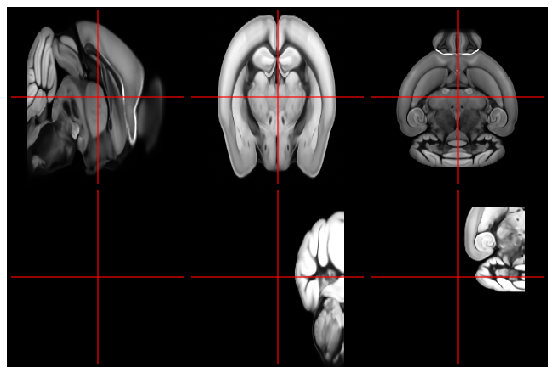

In [106]:
ants.from_nibabel(moving).resample_image(fixed.shape, 1, 0).plot_ortho_double(ants.from_nibabel(fixed))

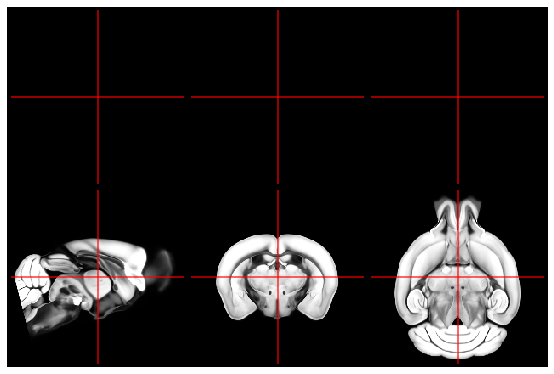

In [110]:
wmv.plot_ortho_double(ants.from_nibabel(fixed))

In [95]:
wmv = wmv.numpy()

In [96]:
nimg = nib.Nifti1Image(wmv, fixed.affine)

In [97]:
nib.save(nimg, "kkk.nii.gz")

## Test matrice generique

In [189]:
import numpy as np
from scipy.io import loadmat, savemat

In [194]:
loadmat("/Users/mahdi/stage-2022-mahdi/tracts/allen2avgt50.mat")

{'AffineTransform_float_3_3': array([[  1.40021634e+00],
        [ -6.94530463e-05],
        [  1.97520960e-04],
        [ -1.14186560e-05],
        [  1.35641217e+00],
        [  3.46407443e-01],
        [ -1.06247142e-04],
        [ -3.46691698e-01],
        [  1.35775852e+00],
        [  3.25480576e+01],
        [  2.24858093e+01],
        [  4.88390350e+00]], dtype=float32),
 'fixed': array([[ 81.35860443],
        [ 94.48912811],
        [ 79.52913666]], dtype=float32)}

In [193]:
loadmat("/Users/mahdi/stage-2022-mahdi/data/transformations_allen2avgt/allen2avgtAffine_50.mat")

{'AffineTransform_float_3_3': array([[  1.40010476e+00],
        [  7.93613726e-05],
        [ -2.72541976e-04],
        [ -1.61930133e-04],
        [  1.35685694e+00],
        [  3.45518261e-01],
        [  1.27313469e-04],
        [ -3.46717477e-01],
        [  1.35826540e+00],
        [  3.25529709e+01],
        [  2.24906101e+01],
        [  4.84793854e+00]], dtype=float32),
 'fixed': array([[ 81.35860443],
        [ 94.48912811],
        [ 79.52913666]], dtype=float32)}

In [134]:
def load_matrix_in_any_format(filepath):
    _, ext = os.path.splitext(filepath)
    if ext == '.txt':
        data = np.loadtxt(filepath)
    elif ext == '.npy':
        data = np.load(filepath)
    elif ext == '.mat':
        # .mat are actually dictionnary. This function support .mat from
        # antsRegistration that encode a 4x4 transformation matrix.
        transfo_dict = loadmat(filepath)
        lps2ras = np.diag([-1, -1, 1])

        rot = transfo_dict['AffineTransform_double_3_3'][0:9].reshape((3, 3))
        trans = transfo_dict['AffineTransform_double_3_3'][9:12]
        offset = transfo_dict['fixed']
        r_trans = (np.dot(rot, offset) - offset - trans).T * [1, 1, -1]

        data = np.eye(4)
        data[0:3, 3] = r_trans
        data[:3, :3] = np.dot(np.dot(lps2ras, rot), lps2ras)
    else:
        raise ValueError('Extension {} is not supported'.format(ext))

    return data

In [ ]:
mat = load_matrix_in_any_format("/Users/mahdi/stage-2022-mahdi/data/transformations_allen2avgt/allen2avgtAffine_50.mat")

In [9]:
imat = np.linalg.inv(mat)

In [ ]:
print(mat)

In [349]:
l = mat.copy()
print(l)

[[  1.40010476e+00   7.93613726e-05   2.72541976e-04  -1.51824951e-02]
 [ -1.61930133e-04   1.35685694e+00  -3.45518261e-01   3.86941071e+01]
 [ -1.27313469e-04   3.46717477e-01   1.35826540e+00   9.10607910e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [370]:
lps2ras = np.diag([-1, -1, 1])

In [372]:
l3 = np.dot(np.dot(lps2ras, l[:3, :3]), lps2ras)

In [373]:
print(l3)

[[  1.40010476e+00   7.93613726e-05  -2.72541976e-04]
 [ -1.61930133e-04   1.35685694e+00   3.45518261e-01]
 [  1.27313469e-04  -3.46717477e-01   1.35826540e+00]]


In [ ]:
l3f = (np.dot(l3, offset) - offset - trans).T * [1, 1, -1]

In [387]:
t = ants.create_ants_transform(matrix=l3, fixed_parameters= l[0:3, 3])

In [388]:
ants.write_transform(t, "test.mat")

In [389]:
print(load_matrix_in_any_format("test.mat"))

[[  1.40010476e+00   7.93613726e-05   2.72541976e-04  -5.48555993e-03]
 [ -1.61930133e-04   1.35685694e+00  -3.45518261e-01   1.69545798e+01]
 [ -1.27313469e-04   3.46717477e-01   1.35826540e+00   1.01535320e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [344]:
moving = np.moveaxis(moving, (0, 1, 2), (1, 2, 0))
moving = np.flip(moving, axis=2)
moving = np.flip(moving, axis=1)

In [407]:
aras = nib.load("/Users/mahdi/stage-2022-mahdi/data/allen_template_50_ras.nii.gz")

In [414]:
x , y, z = nib.aff2axcodes(aras.affine)

In [415]:
print(x, y, z)

P I R


In [3]:
ornt_ras = nib.orientations.axcodes2ornt(('R', 'A', 'S'))

In [4]:
ornt_pir = nib.orientations.axcodes2ornt(('P', 'I', 'R'))

In [5]:
ornt_pir2ras = nib.orientations.ornt_transform(ornt_pir,ornt_ras)

In [6]:
ornt_ras2pir = nib.orientations.ornt_transform(ornt_ras,ornt_pir)

In [69]:
print(ornt_ras2pir)

[[ 2.  1.]
 [ 0. -1.]
 [ 1. -1.]]


In [438]:
aras_reorient = nib.orientations.apply_orientation(aras.get_fdata(), ornt_pir2ras)

In [446]:
moving_reorient = nib.orientations.apply_orientation(moving, ornt_pir2ras)

In [447]:
print(aras.shape,aras_reorient.shape, moving_reorient.shape)

(264, 160, 228) (228, 264, 160) (228, 264, 160)


In [461]:
# lpi = ants.apply_ants_transform_to_image(
#     ants.read_transform("/Users/mahdi/stage-2022-mahdi/tracts/allen2avgt50.mat"),
#     ants.from_numpy(moving_reorient.astype(np.float32)),
#     reference=ants.from_numpy(fixed.get_fdata().astype(np.float32)),
#     interpolation='nearestNeighbor'
# )
lpi = ants.apply_transforms(fixed=ants.from_numpy(fixed.get_fdata().astype(np.float32)),  
                        moving=ants.from_numpy(moving_reorient.astype(np.float32)),
                                          transformlist="/Users/mahdi/stage-2022-mahdi/tracts/allen2avgt50.mat",
                                          interpolator="nearestNeighbor")

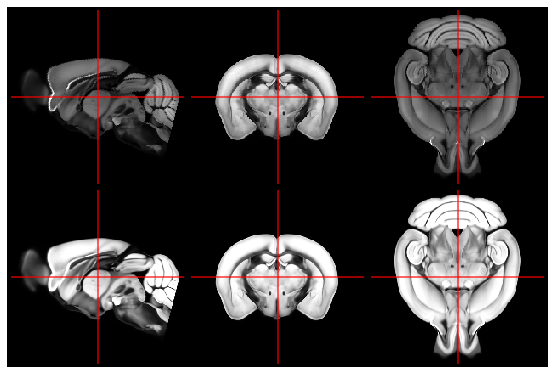

In [462]:
lpi.plot_ortho_double(ants.from_numpy(fixed.get_fdata().astype(np.float32)))

In [443]:
nimg = nib.Nifti1Image(lpi.numpy(), fixed.affine)

In [444]:
nib.save(nimg, "kkk.nii.gz")

In [ ]:
print(moving)

# Essais reorientation d'un point

### du allen à mib user

In [42]:
ornt_pir2ras

array([[ 1., -1.],
       [ 2., -1.],
       [ 0.,  1.]])

In [43]:
point_pir_um = [4200, 1670, 7070]

In [50]:
point_pir_100um = [4200//100, 1670//100, 7070//100]

In [51]:
4200//100, 1670//100, 7070//100

(42, 16, 70)

In [52]:
fake_allen_vol = np.zeros((132, 80, 114), np.int32)

In [53]:
fake_allen_vol[42, 16, 70] = 1

In [54]:
fake_allen_vol_reorient = nib.orientations.apply_orientation(fake_allen_vol, ornt_pir2ras)

In [55]:
tx = ants.read_transform("/Users/mahdi/stage-2022-mahdi/data/transformations_allen2avgt/allen2avgtAffine_100.mat")

In [56]:
a,e,t = np.where(fake_allen_vol_reorient == np.amax(fake_allen_vol_reorient))
pppot = [a[0], e[0], t[0]]
print(pppot)
print(tx.invert().apply_to_point(pppot))
print(list(map(int,tx.invert().apply_to_point(pppot))))

[70, 89, 63]
(100.00164031982422, 129.90628051757812, 119.96710205078125)
[100, 129, 119]


### de mib user a allen

In [30]:
tx = ants.read_transform("/Users/mahdi/stage-2022-mahdi/data/transformations_allen2avgt/allen2avgtAffine_100.mat")

In [598]:
allen_user_pt = tx.apply_to_point(tx.invert().apply_to_point(pppot))

In [599]:
print(list(map(int, allen_user_pt)) )

[70, 88, 62]


In [591]:
fake_allen_vol = np.zeros((264//2, 160//2, 228//2), np.int32)

In [592]:
fake_allen_vol_reorient = nib.orientations.apply_orientation(fake_allen_vol, ornt_pir2ras)

In [593]:
fake_allen_vol_reorient[70, 88, 62] = 1

In [594]:
ornt_ras2pir = nib.orientations.ornt_transform(ornt_ras,ornt_pir)

In [595]:
fake_allen_vol_revert = nib.orientations.apply_orientation(fake_allen_vol_reorient, ornt_ras2pir)

In [596]:
x, y, z = np.where(fake_allen_vol_revert == np.amax(fake_allen_vol_revert))

In [597]:
x[0]*100, y[0]*100, z[0]*100

(4300, 1700, 7000)

# test de reorientation sans convertir en int

In [8]:
ornt_pir2ras

array([[ 1., -1.],
       [ 2., -1.],
       [ 0.,  1.]])

In [147]:
list(map(int,ornt_pir2ras[:,0].tolist())).index(int(ornt_pir2ras[1][0]))

1

In [80]:
bbx_aln = [132, 80, 114]

In [152]:
point_pir = [47.27, 33.12, 30.1]

In [153]:
point_ras = [0 ,0 , 0]
point_ras[int(ornt_pir2ras[0][0])] = point_pir[0] * ornt_ras2pir[int(ornt_pir2ras[0][0])][1]
point_ras[int(ornt_pir2ras[1][0])] = point_pir[1] * ornt_ras2pir[int(ornt_pir2ras[1][0])][1]
point_ras[int(ornt_pir2ras[2][0])] = point_pir[2] * ornt_ras2pir[int(ornt_pir2ras[2][0])][1]
print(point_ras)
for i in range(len(point_ras)):
    if point_ras[i] < 0:
        point_ras[i] += (bbx_aln[
            int(ornt_pir2ras[:,0].tolist().index(i))
        ]-1)
print(point_ras)
user_point = tx.invert().apply_to_point(point_ras)
print(user_point)

[30.100000000000001, -47.270000000000003, -33.119999999999997]
[30.100000000000001, 83.72999999999999, 45.880000000000003]
(42.99003982543945, 128.63873291015625, 94.40989685058594)


In [154]:
volume = np.zeros(bbx_aln, np.int32)
pt = list(map(int,point_pir))
volume[pt[0], pt[1], pt[2]] = 1
volume_reorient = nib.orientations.apply_orientation(volume, ornt_pir2ras)
x, y, z = np.where(volume_reorient == np.amax(volume_reorient))
print(x[0], y[0], z[0])
ptt = tx.invert().apply_to_point((x[0], y[0], z[0]))
print(ptt)

30 84 46
(42.84712219238281, 128.97012329101562, 94.67137908935547)


# dezdezdz

In [93]:
l = np.arange(5)

In [94]:
l

array([0, 1, 2, 3, 4])

In [97]:
def add(pt, res):
    return pt*res

In [106]:
import functools as fc


In [108]:
list(map(fc.partial(add, res=2),l))

[0, 2, 4, 6, 8]

In [ ]:
from dipy.tracking.life import transform_streamlines

In [24]:
vollll = np.zeros((1320,800, 1140), np.int32)

In [25]:
llllov = nib.orientations.apply_orientation(vollll, ornt_pir2ras)

In [26]:
llllov[333, 333, 333] = 1

In [1]:
def argmax(a):
    return max(range(len(a)), key=lambda x: a[x])


In [20]:
a = 78.32

In [21]:
[69.54, 31.7 ,  7.01]
[6954.000091552734, 3170.0000762939453, 701.0000228881836]
[6954, 3170, 701]

[6954, 3170, 701]

In [27]:
vol_int = np.zeros((132, 80, 114), np.int32)

In [28]:
vol_dec = np.zeros((132, 80, 114), np.int32)

In [ ]:
aras_reorient = nib.orientations.apply_orientation(aras.get_fdata(), ornt_pir2ras)

## nrrd pir to nii pir

In [159]:
import nrrd
import nibabel as nib

In [161]:
nrrd_allen, _ = nrrd.read("/Users/mahdi/.allen2tract/allen_template_100.nrrd") 

In [170]:
aff = np.eye(4) * 100/1e3
aff[3,3] = 1
aff

array([[ 0.1,  0. ,  0. ,  0. ],
       [ 0. ,  0.1,  0. ,  0. ],
       [ 0. ,  0. ,  0.1,  0. ],
       [ 0. ,  0. ,  0. ,  1. ]])

In [171]:
nifti_allen = nib.Nifti1Image(nrrd_allen, aff)

In [181]:
nib.save(nifti_allen, "allen_100.nii.gz")

In [187]:
nallen = nib.load("/Users/mahdi/stage-2022-mahdi/data/allen_template_50_ras.nii.gz")

In [188]:
nib.aff2axcodes(nallen.affine)

('P', 'I', 'R')